Install and Import Statements

In [ ]:
pip install pandas numpy matplotlib nltk statsmodels scipy tqdm transformers torch
pip install transformers torch

In [32]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

Read CSV files to dataframes, filter, and concatinate into one dataframe

In [6]:
df_trump = pd.read_csv("C:/Users/kateb/Downloads/hashtag_donaldtrump.csv", engine="python", encoding="utf-8", on_bad_lines="skip")
df_biden = pd.read_csv("C:/Users/kateb/Downloads/hashtag_joebiden.csv", engine="python", encoding="utf-8", on_bad_lines="skip")

In [7]:
poll = pd.read_csv("C:/Users/kateb/OneDrive/Desktop/Favorability.csv")

In [8]:
df_trump["candidate"] = "Trump"
df_biden["candidate"] = "Biden"

df = pd.concat([df_trump, df_biden], ignore_index=True)

Filter by state code to have two extreme behaviors to compare. Biden won Calfornia by the widest margin. Trump won Tennessee by the widest margin.

In [9]:
df = df[df["state_code"].isin(["CA", "TN"])]

In [10]:
df.shape

(64755, 22)

Ensure dates are in datetime format, and create a pre and post election period variable. We did not ultimately use the pre and post election variable in our analysis, but we have left it as an artifact of our iteration, and incase is is of interest to others.

In [16]:
df["created_at"] = pd.to_datetime(df["created_at"])

df = df[(df["created_at"] >= "2020-10-15") & (df["created_at"] <= "2020-11-09")]
df["period"] = df["created_at"].apply(lambda x: "Pre-Election" if x < pd.Timestamp("2020-11-03") else "Post-Election")

df["created_at"] = df["created_at"].dt.date

Prepare text to undergo sentiment analysis, initialize VADER model, and run on dataframe

In [17]:
df = df[df["tweet"].str.contains(r"[a-zA-Z]", regex=True, na=False)]

In [18]:
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()
df["sentiment"] = df["tweet"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kateb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
df[["tweet", "sentiment", "state_code", "period", "candidate", "created_at"]].head()

,tweet,sentiment,state_code,period,candidate,created_at
5,@CLady62 Her 15 minutes were over long time ag...,-0.4912,CA,Pre-Election,Trump,2020-10-15
12,#Trump #PresidentTrump #Trump2020LandslideVict...,0.0000,CA,Pre-Election,Trump,2020-10-15
34,#BlacksForTrump \n#BlackVoicesForTrump \n#Bide...,0.0000,CA,Pre-Election,Trump,2020-10-15
42,"#TheWeek: ""#Trump in Penn: ""I saved suburbia. ...",-0.3174,CA,Pre-Election,Trump,2020-10-15
44,#Trump is tearing up #Biden at the #TrumpRally...,0.0000,CA,Pre-Election,Trump,2020-10-15


Create a variable for sentiment class. The threshold was set low to ensure that even mildly positive or negative tweets were included in our final analysis

In [20]:
for i, r in df.iterrows():
    if r['sentiment'] > 0.01:
        df.at[i, 'VADER_class'] = 'Positive'
        df.at[i, 'positive'] = 1
        df.at[i, 'negative'] = 0
        df.at[i, 'neutral'] = 0
    elif r['sentiment'] < -0.01:
        df.at[i, 'VADER_class'] = 'Negative'
        df.at[i, 'positive'] = 0
        df.at[i, 'negative'] = 1
        df.at[i, 'neutral'] = 0
    else:
        df.at[i, 'VADER_class'] = 'Neutral'
        df.at[i, 'positive'] = 0
        df.at[i, 'negative'] = 0
        df.at[i, 'neutral'] = 1

In [21]:
df[["tweet", "sentiment", "state_code", "period", "candidate", "created_at", "VADER_class", "positive", "negative", "neutral"]].head()

,tweet,sentiment,state_code,period,candidate,created_at,VADER_class,positive,negative,neutral
5,@CLady62 Her 15 minutes were over long time ag...,-0.4912,CA,Pre-Election,Trump,2020-10-15,Negative,0.0,1.0,0.0
12,#Trump #PresidentTrump #Trump2020LandslideVict...,0.0000,CA,Pre-Election,Trump,2020-10-15,Neutral,0.0,0.0,1.0
34,#BlacksForTrump \n#BlackVoicesForTrump \n#Bide...,0.0000,CA,Pre-Election,Trump,2020-10-15,Neutral,0.0,0.0,1.0
42,"#TheWeek: ""#Trump in Penn: ""I saved suburbia. ...",-0.3174,CA,Pre-Election,Trump,2020-10-15,Negative,0.0,1.0,0.0
44,#Trump is tearing up #Biden at the #TrumpRally...,0.0000,CA,Pre-Election,Trump,2020-10-15,Neutral,0.0,0.0,1.0


Save to CSV for later analysis in R

In [320]:
df.to_csv(r"C:\Users\kateb\OneDrive\Desktop\df.csv", index=False)

Create a percent classification score to have a like score to compare to traditional polling data

In [24]:
percent_pos = (df.groupby(["created_at", "candidate"])["positive"].mean().mul(100).reset_index())
percent_neg = (df.groupby(["created_at", "candidate"])["negative"].mean().mul(100).reset_index())
percent_neu = (df.groupby(["created_at", "candidate"])["neutral"].mean().mul(100).reset_index())

Plot the percent positive sentiment analysis for both candidates vs the positive polling for both candidates

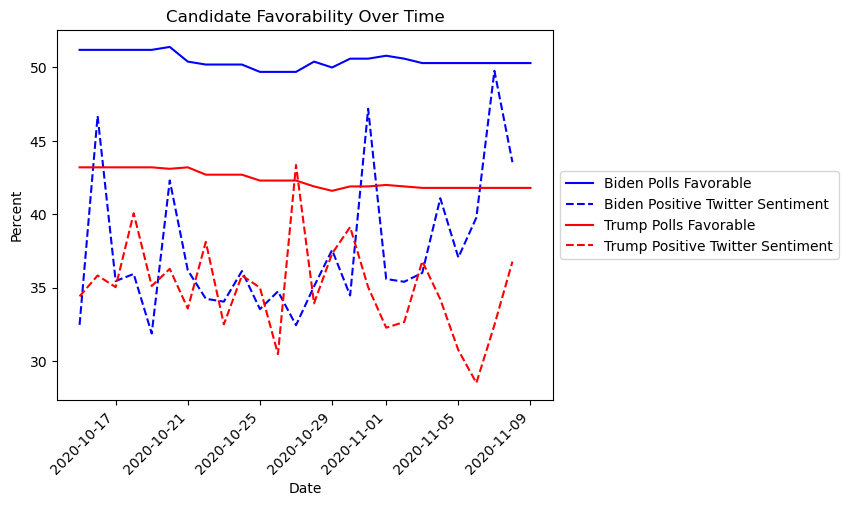

In [25]:
poll["Date"] = pd.to_datetime(poll["Date"], errors="coerce")
percent_pos["created_at"] = pd.to_datetime(percent_pos["created_at"], errors="coerce")

biden_pos = percent_pos.loc[percent_pos["candidate"] == "Biden", ["created_at", "positive"]].sort_values("created_at")
trump_pos = percent_pos.loc[percent_pos["candidate"] == "Trump", ["created_at", "positive"]].sort_values("created_at")

plt.figure()
plt.plot(poll["Date"], poll["Biden Favorable"], label = "Biden Polls Favorable", color = "blue")
plt.plot(biden_pos["created_at"], biden_pos["positive"], label="Biden Positive Twitter Sentiment", color="blue", linestyle="--")
plt.plot(poll["Date"], poll["Trump Favorable"], label = "Trump Polls Favorable", color = "red")
plt.plot(trump_pos["created_at"], trump_pos["positive"], label="Trump Positive Twitter Sentiment", color="red", linestyle="--")
plt.title("Candidate Favorability Over Time")
plt.xlabel("Date")
plt.xticks(rotation = 45, ha="right")
plt.ylabel("Percent")
plt.legend(loc="center left", bbox_to_anchor = (1, 0.5))
plt.savefig("C:/Users/kateb/OneDrive/Desktop/favorability_chart.png", dpi = 300, bbox_inches = "tight")
plt.show()

Configure polling and sentimetn data for use in an ANOVA. Data must be in long format

In [26]:
poll = poll.rename(columns={"Biden Favorable": "Biden", "Trump Favorable": "Trump"})
poll_long = (poll.melt(id_vars="Date", value_vars=["Biden", "Trump"], var_name="candidate", value_name="favorability"))
poll_long.head()

,Date,candidate,favorability
0,2020-10-15,Biden,51.2
1,2020-10-16,Biden,51.2
2,2020-10-17,Biden,51.2
3,2020-10-18,Biden,51.2
4,2020-10-19,Biden,51.2


In [27]:
percent_pos = percent_pos.rename(columns = {"created_at": "date"})
poll_long = poll_long.rename(columns = {"Date": "date"})

merged = pd.merge(poll_long, percent_pos, on = ["date", "candidate"], how = "inner")

In [29]:
anova_df = merged.melt(id_vars = ["date", "candidate"], value_vars = ["favorability", "positive"], var_name = "measure",
                       value_name = "score").sort_values(["date", "candidate", "measure"]).reset_index()

In [31]:
anova_df.to_csv(r"C:\Users\kateb\OneDrive\Desktop\anova_df.csv", index=False)

Descriptive statistics based on state, candidate, and period. Artifacts of older analysis, but perhaps relevant to others.

In [34]:
descriptive = (df.groupby(["candidate", "state_code", "period"])
      .agg(mean_sentiment=("sentiment", "mean"),
           sd_sentiment=("sentiment", "std"),
           n_tweets=("tweet_id", "count"))
      .reset_index())

descriptive

,candidate,state_code,period,mean_sentiment,sd_sentiment,n_tweets
0,Biden,CA,Post-Election,0.171463,0.451565,11748
1,Biden,CA,Pre-Election,0.036706,0.463798,14068
2,Biden,TN,Post-Election,0.138223,0.364445,2317
3,Biden,TN,Pre-Election,0.054551,0.406615,1557
4,Trump,CA,Post-Election,0.009420,0.468998,10704
5,Trump,CA,Pre-Election,-0.020463,0.485665,20451
6,Trump,TN,Post-Election,0.031138,0.392742,1917
7,Trump,TN,Pre-Election,0.017826,0.447126,1992


Create filter for positive and negative sentiment by state for later graphing

In [35]:
df["pos_neg_ratio"] = df["sentiment"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

In [36]:
df.groupby(["state_code", "period"])["pos_neg_ratio"].mean()

state_code  period       
CA          Post-Election   0.148227
            Pre-Election    0.020221
TN          Post-Election   0.145489
            Pre-Election    0.087630
Name: pos_neg_ratio, dtype: float64

In [37]:
grouped = (df.groupby(["candidate", "state_code", "created_at"]).agg(pos_count=("positive", "sum"), neg_count=("negative", "sum"),
                                                                     total_tweets=("tweet_id", "count")).reset_index())

In [38]:
grouped["pos_neg_ratio"] = grouped["pos_count"] / (grouped["neg_count"] + 1e-6)

Create graph of senitment shift over time for candidates by state using raw data.

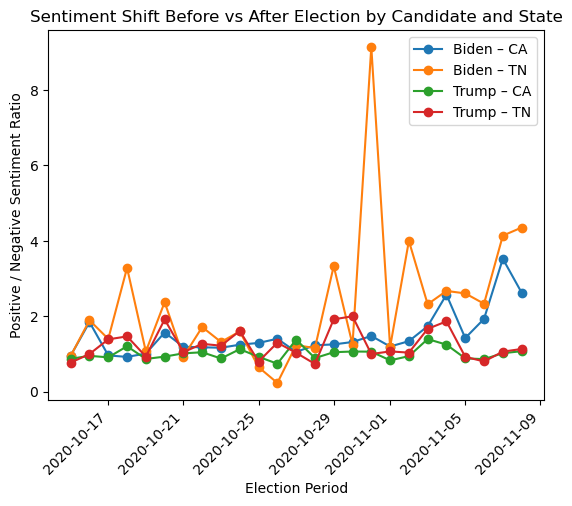

In [41]:
plt.figure()

for candidate in ["Biden", "Trump"]:
    for state in ["CA", "TN"]:
        subset = grouped[(grouped["candidate"] == candidate) & (grouped["state_code"] == state)]
        plt.plot(subset["created_at"], subset["pos_neg_ratio"], marker="o", label=f"{candidate} – {state}")

plt.xlabel("Election Period")
plt.xticks(rotation = 45, ha="right")
plt.ylabel("Positive / Negative Sentiment Ratio")
plt.title("Sentiment Shift Before vs After Election by Candidate and State")
plt.legend()
plt.savefig("C:/Users/kateb/OneDrive/Desktop/bystate_chart.png", dpi = 300, bbox_inches = "tight")
plt.show()